<a href="https://colab.research.google.com/github/GiannaSal/phase-2-project/blob/charity/EDA_consistently_top_earning_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis: Identifying Consistently Top-Earning Movie Genres

**Business question:** Which genre *consistently* earns the most at the box office?

**What “consistently” means in this notebook**
- A genre ranks **#1 (or top 3)** in total earnings in **many years**, not just overall.
- It also shows **stable performance** (lower year-to-year volatility) rather than one-off spikes.


## 1. Import Libraries

In [25]:

import os
import re
import zipfile
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

# Display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
sns.set_theme(style="whitegrid")

## 2. Loading the Data

In [26]:
import os
import re
import zipfile
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

# Display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
sns.set_theme(style="whitegrid")

# File paths

DATA_PATH = Path("im.db.zip")  # Corrected path
EXTRACT_DIR = Path("data_extracted")
EXTRACT_DIR.mkdir(exist_ok=True, parents=True)

def normalize_title(s: str) -> str:
    """Normalize titles to improve joins (lowercase, strip, remove punctuation/spaces)."""
    if pd.isna(s):
        return ""
    s = str(s).lower().strip()
    s = re.sub(r"[^a-z0-9]+", "", s)
    return s

def coerce_money_to_float(x):
    """
    Coerce money-like strings to floats.
    Examples: '1,234,567', '$1,234,567', None
    """
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).strip()
    s = s.replace("$", "").replace(",", "")
    s = re.sub(r"[^0-9.\-]", "", s)
    return float(s) if s not in ("", ".", "-", "--") else np.nan

def load_from_zip_or_file(path: Path):
    """
    Load a dataset from:
    - a zipped sqlite db (im.db.zip -> im.db)
    - a direct sqlite db (im.db)
    - a zipped csv/tsv
    - a direct csv/tsv file
    Returns: dict of dataframes + metadata
    """
    if not path.exists():
        raise FileNotFoundError(f"Could not find {path.resolve()}")

    info = {"source_path": str(path), "mode": None, "details": {}}
    dfs = {}
    zip_attempt_failed = False

    if path.suffix.lower() == ".zip":
        try:
            info["mode"] = "zip"
            with zipfile.ZipFile(path, "r") as zf:
                members = zf.namelist()
                info["details"]["zip_members"] = members

                db_candidates = [m for m in members if m.lower().endswith((".db", ".sqlite", ".sqlite3"))]
                if db_candidates:
                    db_name = db_candidates[0]
                    zf.extract(db_name, EXTRACT_DIR)
                    db_path = EXTRACT_DIR / db_name
                    info["details"]["db_path"] = str(db_path)

                    conn = sqlite3.connect(db_path)
                    tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)["name"].tolist()
                    info["details"]["tables"] = tables

                    for t in tables:
                        dfs[t] = pd.read_sql(f"SELECT * FROM {t};", conn)
                    conn.close()

                    return dfs, info

                csv_candidates = [m for m in members if m.lower().endswith((".csv", ".tsv"))]
                if csv_candidates:
                    name = csv_candidates[0]
                    zf.extract(name, EXTRACT_DIR)
                    file_path = EXTRACT_DIR / name
                    sep = "\t" if file_path.suffix.lower() == ".tsv" else ","
                    dfs["data"] = pd.read_csv(file_path, sep=sep)
                    info["details"]["table_like_file"] = str(file_path)
                    return dfs, info

                raise ValueError(f"Zip file found, but no .db/.sqlite or .csv/.tsv members detected. Members: {members[:20]} ...")
        except zipfile.BadZipFile:
            print(f"Warning: '{path.name}' is named as a zip file but is not a valid zip. Trying to load as a direct SQLite database instead.")
            zip_attempt_failed = True
        except Exception as e:
            # Catch other potential errors during zip processing
            print(f"Error processing '{path.name}' as a zip file: {e}. Trying to load as a direct SQLite database if applicable.")
            zip_attempt_failed = True

    # Handle direct DB files (e.g., im.db or a .db file misnamed as .db.zip)
    if path.suffix.lower() in (".db", ".sqlite", ".sqlite3") or (path.suffix.lower() == ".zip" and zip_attempt_failed):
        try:
            info["mode"] = "db_direct"
            info["details"]["db_path"] = str(path)
            conn = sqlite3.connect(path)
            tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)["name"].tolist()
            info["details"]["tables"] = tables
            for t in tables:
                dfs[t] = pd.read_sql(f"SELECT * FROM {t};", conn)
            conn.close()
            return dfs, info
        except sqlite3.Error as e:
            if zip_attempt_failed:
                raise ValueError(f"'{path.name}' is neither a valid zip file nor a valid SQLite database. Please check your file.") from e
            else:
                raise ValueError(f"Error loading '{path.name}' as a direct SQLite database: {e}") from e


    elif path.suffix.lower() in (".csv", ".tsv"):
        info["mode"] = "flatfile"
        sep = "\t" if path.suffix.lower() == ".tsv" else ","
        dfs["data"] = pd.read_csv(path, sep=sep)
        return dfs, info

    raise ValueError(f"Unsupported file type for {path.name}. Provide a .zip (containing .db/.csv/.tsv), .db, .csv, or .tsv.")

dfs, load_info = load_from_zip_or_file(DATA_PATH)
display(Markdown(f"**Loaded from:** `{load_info['source_path']}`  \n**Mode:** `{load_info['mode']}`"))
display(load_info)


**Loaded from:** `im.db.zip`  
**Mode:** `zip`

{'source_path': 'im.db.zip',
 'mode': 'zip',
 'details': {'zip_members': ['im.db'],
  'db_path': 'data_extracted/im.db',
  'tables': ['movie_basics',
   'directors',
   'known_for',
   'movie_akas',
   'movie_ratings',
   'persons',
   'principals',
   'writers']}}

## 3. Inspecting the Data

In [27]:

table_names = list(dfs.keys())
display(Markdown(f"### Tables / data objects found ({len(table_names)}):"))
display(table_names)

movie_basics = dfs.get("movie_basics")
movie_ratings = dfs.get("movie_ratings")

if movie_basics is None:
    movie_basics = dfs.get("data")

display(Markdown("### Preview: movie_basics (or primary dataframe)"))
display(movie_basics.head())

display(Markdown("### Shape"))
display(movie_basics.shape)

display(Markdown("### Columns and dtypes"))
display(movie_basics.dtypes)

display(Markdown("### Summary statistics (numeric)"))
display(movie_basics.describe(include=[np.number]))

if movie_ratings is not None:
    display(Markdown("### Preview: movie_ratings"))
    display(movie_ratings.head())
    display(Markdown("### movie_ratings summary (numeric)"))
    display(movie_ratings.describe(include=[np.number]))

### Tables / data objects found (8):

['movie_basics',
 'directors',
 'known_for',
 'movie_akas',
 'movie_ratings',
 'persons',
 'principals',
 'writers']

### Preview: movie_basics (or primary dataframe)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


### Shape

(146144, 6)

### Columns and dtypes

,0
movie_id,object
primary_title,object
original_title,object
start_year,int64
runtime_minutes,float64
genres,object


### Summary statistics (numeric)

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


### Preview: movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


### movie_ratings summary (numeric)

,averagerating,numvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


## 4. Data Cleaning

In [28]:

df = movie_basics.copy()

# Standardizing likely column names
colmap = {}
if "start_year" in df.columns and "year" not in df.columns:
    colmap["start_year"] = "year"
if "primary_title" in df.columns and "title" not in df.columns:
    colmap["primary_title"] = "title"
df = df.rename(columns=colmap)

# Ensuring year numeric
if "year" in df.columns:
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# Normalize to a "genres" column
if "genres" not in df.columns and "genre" in df.columns:
    df["genres"] = df["genre"]

display(Markdown("### Missing values (top columns)"))
display(df.isna().mean().sort_values(ascending=False).head(15))

# Drop missing key fields
df = df.dropna(subset=[c for c in ["year", "genres"] if c in df.columns]).copy()

# Clean genres
df["genres"] = df["genres"].astype(str).str.strip()
df = df[df["genres"].str.lower().ne("nan")].copy()

# Split multi-genres
df["genre_list"] = df["genres"].str.split(",")
df["genre_list"] = df["genre_list"].apply(lambda lst: [g.strip() for g in lst if isinstance(g, str) and g.strip()])

# Attach ratings if present
if movie_ratings is not None and "movie_id" in df.columns and "movie_id" in movie_ratings.columns:
    df = df.merge(movie_ratings, on="movie_id", how="left")

display(Markdown("### Cleaned dataframe preview"))
display(df.head())
display(Markdown(f"Rows after cleaning: **{len(df):,}**"))

### Missing values (top columns)

,0
runtime_minutes,0.217176
genres,0.037005
original_title,0.000144
movie_id,0.000000
title,0.000000
year,0.000000


### Cleaned dataframe preview

,movie_id,title,original_title,year,runtime_minutes,genres,genre_list,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama","[Action, Crime, Drama]",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama","[Biography, Drama]",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,[Drama],6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama","[Comedy, Drama]",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy","[Comedy, Drama, Fantasy]",6.5,119.0


Rows after cleaning: **140,736**

## 5. Creating an Earnings Metric

In [29]:

# Goal: create df['earnings'] as numeric suitable for summing by year & genre.

earnings_candidates = [
    "earnings", "earning", "gross", "worldwide_gross", "domestic_gross", "foreign_gross", "revenue", "box_office"
]
found_earnings_col = next((c for c in earnings_candidates if c in df.columns), None)

if found_earnings_col is not None:
    df["earnings"] = df[found_earnings_col].apply(coerce_money_to_float)
    earnings_mode = f"direct:{found_earnings_col}"
else:
    # Try to merge with a box office file if present locally
    possible_boxoffice_files = [
        Path("bom.movie_gross.csv.gz"),
        Path("box.movie_gross.csv.gz"),
        Path("data/bom.movie_gross.csv.gz"),
        Path("zippedData/bom.movie_gross.csv.gz"),
    ]
    boxoffice_path = next((p for p in possible_boxoffice_files if p.exists()), None)

    if boxoffice_path is not None:
        box = pd.read_csv(boxoffice_path)

        box_cols = {c.lower(): c for c in box.columns}
        title_col = box_cols.get("title")
        year_col = box_cols.get("year")

        dom_col = box_cols.get("domestic_gross")
        for_col = box_cols.get("foreign_gross")
        gross_col = box_cols.get("gross") or box_cols.get("worldwide_gross") or box_cols.get("earnings")

        if title_col is None or year_col is None:
            raise ValueError("Box office file found but it doesn't have obvious title/year columns.")

        if dom_col is not None:
            box["domestic_gross"] = box[dom_col].apply(coerce_money_to_float)
        if for_col is not None:
            box["foreign_gross"] = box[for_col].apply(coerce_money_to_float)
        if gross_col is not None and "gross" not in box.columns:
            box["gross"] = box[gross_col].apply(coerce_money_to_float)

        if "domestic_gross" in box.columns or "foreign_gross" in box.columns:
            box["earnings"] = box.get("domestic_gross", 0).fillna(0) + box.get("foreign_gross", 0).fillna(0)
            if "gross" in box.columns:
                mask = box["earnings"].eq(0) & box["gross"].notna()
                box.loc[mask, "earnings"] = box.loc[mask, "gross"]
        elif "gross" in box.columns:
            box["earnings"] = box["gross"]
        else:
            raise ValueError("Found a box office file, but could not locate gross/earnings columns.")

        # Join keys
        if "title" not in df.columns:
            raise ValueError("No title column found in the primary dataset to merge on.")
        df["title_key"] = df["title"].apply(normalize_title)
        box["title_key"] = box[title_col].apply(normalize_title)
        box["year"] = pd.to_numeric(box[year_col], errors="coerce").astype("Int64")

        df = df.merge(box[["title_key", "year", "earnings"]], on=["title_key", "year"], how="left")
        earnings_mode = f"merged:{boxoffice_path.name}"

        display(Markdown(f"✅ Merged earnings from `{boxoffice_path}`."))
        display(Markdown(f"Matched earnings (non-null): **{df['earnings'].notna().sum():,}** / {len(df):,}"))
    else:
        # Fallback proxy (NOT box office)
        if "numvotes" in df.columns:
            df["earnings"] = pd.to_numeric(df["numvotes"], errors="coerce").astype(float)
            earnings_mode = "proxy:numvotes"
        else:
            raise ValueError(
                "No earnings column was found and no box office file was detected locally. "
                "Add a dataset with earnings/gross (e.g., bom.movie_gross.csv.gz) and re-run."
            )

display(Markdown(f"**Earnings metric mode:** `{earnings_mode}`"))

df["earnings"] = pd.to_numeric(df["earnings"], errors="coerce")
df = df.dropna(subset=["earnings", "year"]).copy()

display(df[["year", "genres", "earnings"]].head())
display(Markdown("### Earnings summary"))
display(df["earnings"].describe())

**Earnings metric mode:** `proxy:numvotes`

,year,genres,earnings
0,2013,"Action,Crime,Drama",77.0
1,2019,"Biography,Drama",43.0
2,2018,Drama,4517.0
3,2018,"Comedy,Drama",13.0
4,2017,"Comedy,Drama,Fantasy",119.0


### Earnings summary

,earnings
count,7.305200e+04
mean,3.562173e+03
std,3.045804e+04
min,5.000000e+00
25%,1.400000e+01
50%,5.000000e+01
75%,2.890000e+02
max,1.841066e+06


## 6. Analysis: Which Genre Consistently Earns the Most?

In [30]:

movies_long = df.explode("genre_list").rename(columns={"genre_list": "genre"}).copy()
movies_long["genre"] = movies_long["genre"].astype(str).str.strip()
movies_long = movies_long[movies_long["genre"].ne("")].copy()

year_genre = (
    movies_long
    .groupby(["year", "genre"], as_index=False)["earnings"]
    .sum()
    .rename(columns={"earnings": "yearly_earnings"})
)

year_genre["rank_in_year"] = year_genre.groupby("year")["yearly_earnings"].rank(method="dense", ascending=False)

top1_counts = (year_genre[year_genre["rank_in_year"] == 1]
               .groupby("genre")
               .size()
               .sort_values(ascending=False)
               .rename("years_ranked_1"))

top3_counts = (year_genre[year_genre["rank_in_year"] <= 3]
               .groupby("genre")
               .size()
               .sort_values(ascending=False)
               .rename("years_in_top3"))

genre_stats = (year_genre
               .groupby("genre")["yearly_earnings"]
               .agg(["mean", "std", "min", "max", "count"])
               .rename(columns={"count": "years_observed"}))

genre_stats["coef_var"] = genre_stats["std"] / genre_stats["mean"]
summary = genre_stats.join(top1_counts, how="left").join(top3_counts, how="left")
summary["years_ranked_1"] = summary["years_ranked_1"].fillna(0).astype(int)
summary["years_in_top3"] = summary["years_in_top3"].fillna(0).astype(int)

summary["consistency_score"] = (summary["years_in_top3"] * 1.0 + summary["years_ranked_1"] * 1.5) / (1 + summary["coef_var"].fillna(0))

display(Markdown("### Genre consistency summary (top 20 by consistency_score)"))
display(summary.sort_values("consistency_score", ascending=False).head(20))

### Genre consistency summary (top 20 by consistency_score)

,mean,std,min,max,years_observed,coef_var,years_ranked_1,years_in_top3,consistency_score
genre,,,,,,,,,
Drama,1.195675e+07,4.850054e+06,874812.0,16925356.0,10,0.405633,8,9,14.939887
Action,1.011617e+07,3.511839e+06,1686120.0,14379096.0,10,0.347151,2,10,9.649994
Adventure,8.423259e+06,3.016160e+06,1440693.0,11452041.0,10,0.358075,0,9,6.627026
Comedy,7.430580e+06,3.113602e+06,593740.0,10293596.0,10,0.419025,0,1,0.704709
Sci-Fi,4.296029e+06,1.845215e+06,1092015.0,7072190.0,10,0.429516,0,1,0.699537
Adult,5.466667e+01,6.429101e+01,8.0,128.0,3,1.176055,0,0,0.000000
Biography,2.160945e+06,1.102001e+06,213503.0,4371674.0,10,0.509963,0,0,0.000000
Crime,3.963136e+06,1.934087e+06,383502.0,7570721.0,10,0.488019,0,0,0.000000
Documentary,4.739345e+05,1.678287e+05,90149.0,615937.0,10,0.354118,0,0,0.000000


## 7. Visualizations

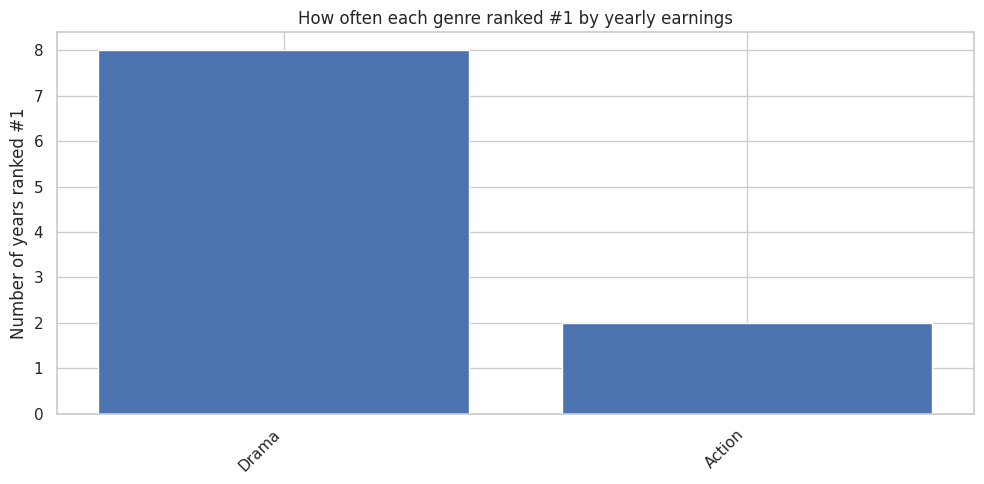

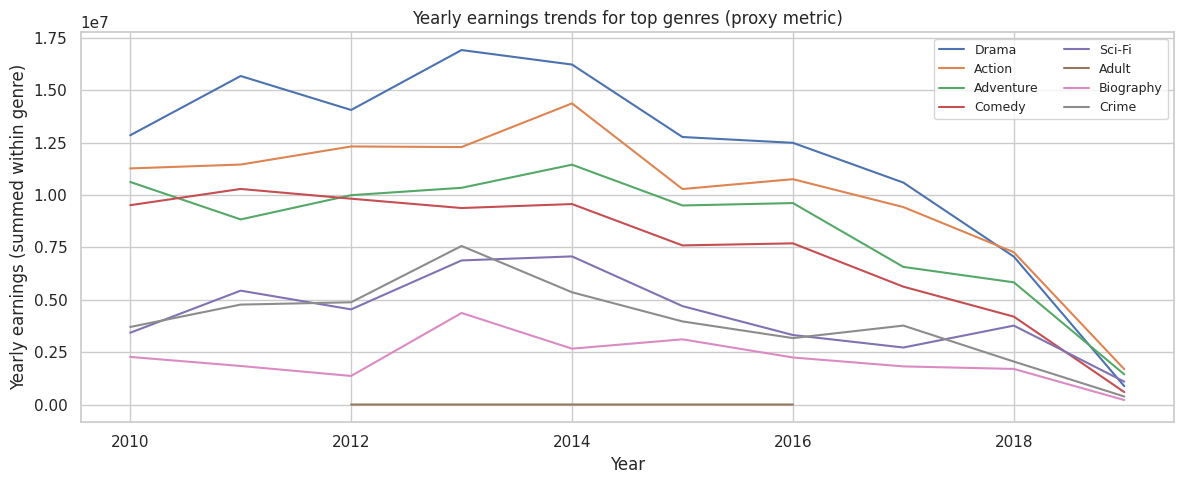

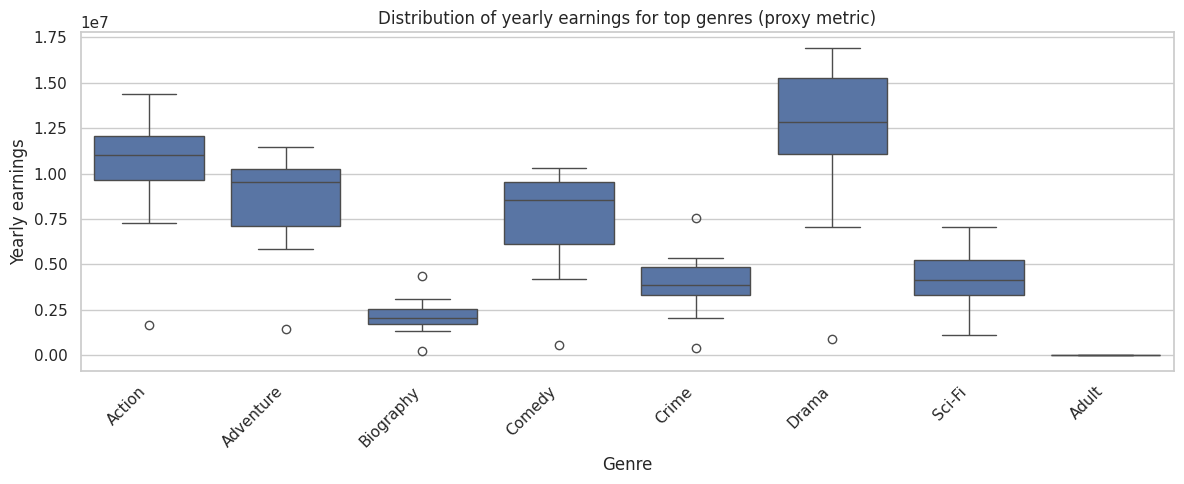

In [31]:

top_genres = summary.sort_values("consistency_score", ascending=False).head(8).index.tolist()
title_suffix = " (proxy metric)" if earnings_mode.startswith("proxy:") else ""

# 7.1 Bar plot: number of years ranked #1
plt.figure(figsize=(10, 5))
top1_plot = top1_counts.reindex(top_genres).dropna().sort_values(ascending=False)
plt.bar(top1_plot.index, top1_plot.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of years ranked #1")
plt.title("How often each genre ranked #1 by yearly earnings")
plt.tight_layout()
plt.show()

# 7.2 Line plot: yearly earnings over time
plt.figure(figsize=(12, 5))
plot_df = year_genre[year_genre["genre"].isin(top_genres)].copy()
for g in top_genres:
    gdf = plot_df[plot_df["genre"] == g].sort_values("year")
    plt.plot(gdf["year"].astype(int), gdf["yearly_earnings"], label=g)

plt.xlabel("Year")
plt.ylabel("Yearly earnings (summed within genre)")
plt.title(f"Yearly earnings trends for top genres{title_suffix}")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# 7.3 Boxplot: distribution
plt.figure(figsize=(12, 5))
box_df = year_genre[year_genre["genre"].isin(top_genres)].copy()
sns.boxplot(data=box_df, x="genre", y="yearly_earnings")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Yearly earnings")
plt.title(f"Distribution of yearly earnings for top genres{title_suffix}")
plt.tight_layout()
plt.show()

## 8. Summary & Recommendations

In [32]:

top_row = summary.sort_values("consistency_score", ascending=False).head(1)
top_genre = top_row.index[0]
top_years1 = int(top_row["years_ranked_1"].iloc[0])
top_top3 = int(top_row["years_in_top3"].iloc[0])
top_mean = float(top_row["mean"].iloc[0])
top_cv = float(top_row["coef_var"].iloc[0]) if pd.notna(top_row["coef_var"].iloc[0]) else np.nan

metric_note = (
    "- **True earnings used** (box office/gross columns found or merged).\n"
    if not earnings_mode.startswith("proxy:")
    else "- **Proxy used**: earnings not present; this run uses `numvotes` as a stand-in.\n"
         "  - To answer true *box office* earnings, add a dataset with `domestic_gross/foreign_gross` or `earnings` "
         "(e.g., `bom.movie_gross.csv.gz`) and re-run.\n"
)

summary_md = f"""
### Key Findings

{metric_note}
- The most consistently top-performing genre by our definition is **{top_genre}**.
- It ranked **#1 in {top_years1} year(s)** and appeared in the **top 3 in {top_top3} year(s)**.
- Its average yearly performance is approximately **{top_mean:,.2f}** with a volatility indicator (CV) of **{top_cv:,.2f}** (lower is more stable).

### Actionable recommendations

1. **Anchor your slate around the consistent winner(s).**
   Use **{top_genre}** as a core category in your annual plan (e.g., 1–2 flagship releases/year), then diversify into 1–2 adjacent genres that also score highly.

2. **Use a portfolio approach (risk management).**
   Combine:
   - a reliable base (consistent genres),
   - a few “swing” projects (higher-variance genres with upside),
   - and mid-budget experiments.

3. **Do the next analysis executives actually act on.**
   Split the top genre into **sub-genres + budget tiers**, and if budget data exists compute ROI (gross/budget).
   High gross alone can be misleading if costs are also high.
"""
display(Markdown(summary_md))


### Key Findings

- **Proxy used**: earnings not present; this run uses `numvotes` as a stand-in.
  - To answer true *box office* earnings, add a dataset with `domestic_gross/foreign_gross` or `earnings` (e.g., `bom.movie_gross.csv.gz`) and re-run.

- The most consistently top-performing genre by our definition is **Drama**.
- It ranked **#1 in 8 year(s)** and appeared in the **top 3 in 9 year(s)**.
- Its average yearly performance is approximately **11,956,750.00** with a volatility indicator (CV) of **0.41** (lower is more stable).

### Actionable recommendations

1. **Anchor your slate around the consistent winner(s).**  
   Use **Drama** as a core category in your annual plan (e.g., 1–2 flagship releases/year), then diversify into 1–2 adjacent genres that also score highly.

2. **Use a portfolio approach (risk management).**  
   Combine:
   - a reliable base (consistent genres),
   - a few “swing” projects (higher-variance genres with upside),
   - and mid-budget experiments.

3. **Do the next analysis executives actually act on.**  
   Split the top genre into **sub-genres + budget tiers**, and if budget data exists compute ROI (gross/budget).  
   High gross alone can be misleading if costs are also high.
